In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

#Для визуализации
import seaborn as sns
import matplotlib.pyplot as plt

#Для моделирования
import scipy.sparse as sparse

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

from fastai.metrics import auc_roc_score
from fastai.collab import *

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/recommendationsv4/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/recommendationsv4/test_v3.csv')
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/recommendationsv4/sample_submission.csv')

In [5]:
train.head()

,verified,reviewTime,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,True,"10 4, 2016",Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,True,"03 1, 2016",Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,True,"06 26, 2016",DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,True,"09 5, 2013",Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,True,"09 14, 2016",Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


In [0]:
test.head()

,Unnamed: 0,verified,reviewTime,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
0,0,True,"10 1, 2016",Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0
1,1,True,"06 29, 2014",pharg,1404000000,2,NaN,NaN,50442,15530,1
2,2,True,"05 19, 2015",dhalex,1431993600,NaN,NaN,NaN,64349,15049,2
3,3,True,"10 5, 2014",Vanessa,1412467200,NaN,{'Flavor:': ' Sweet Rose'},NaN,26206,11957,3
4,4,True,"11 11, 2013",R Mohrman,1384128000,3,"{'Size:': ' 15 Ounce (Pack of 12)', 'Flavor:':...",NaN,59366,12173,4


In [6]:
VAL_SIZE = test.shape[0]/train.shape[0]
VAL_SIZE

0.3333333333333333

In [7]:
train = train[['userid','itemid','rating']]
train.head()

,userid,itemid,rating
0,102179,37138,1.0
1,3625,17322,1.0
2,39495,5600,1.0
3,72854,30249,1.0
4,74859,4349,1.0


In [8]:
#готовлю трейн для обучения модели
data = CollabDataBunch.from_df(train, seed=42,valid_pct=VAL_SIZE)
#data = CollabDataBunch.from_df(train, seed=42, valid_pct=VAL_SIZE, user_name='userid', item_name='itemid', rating_name='rating')
data.show_batch()

userid,itemid,target
73112,23431,1.0
30051,12596,1.0
10246,5648,1.0
42231,1506,0.0
36588,25751,1.0


In [9]:
train.rating.min(), train.rating.max()

(0.0, 1.0)

In [0]:
learn = collab_learner(data, n_factors=50, metrics=[auc_roc_score], y_range=(0.0, 1.0), wd=1e-1)
#learn = collab_learner(data, use_nn=True, emb_szs={'userid': 40, 'itemid':40}, layers=[256, 128],y_range=(0.0, 1.0))

In [11]:
#learn.lr_find() # find learning rate
#learn.recorder.plot() # plot learning rate graph

from fastai.train import lr_find
lr_find(learn)
learn.recorder.plot_metrics

epoch,train_loss,valid_loss,auc_roc_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


<bound method Recorder.plot_metrics of Recorder
learn: CollabLearner(data=TabularDataBunch;

Train: LabelList (571930 items)
x: CollabList
userid 3625; itemid 17322; ,userid 39495; itemid 5600; ,userid 72854; itemid 30249; ,userid 74859; itemid 4349; ,userid 27865; itemid 931; 
y: FloatList
1.0,1.0,1.0,1.0,1.0
Path: .;

Valid: LabelList (285965 items)
x: CollabList
userid 34039; itemid 29834; ,userid 7236; itemid 31638; ,userid 20075; itemid 5354; ,userid 99186; itemid 8265; ,userid 22802; itemid 36571; 
y: FloatList
1.0,1.0,1.0,1.0,1.0
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(125753, 50)
  (i_weight): Embedding(40963, 50)
  (u_bias): Embedding(125753, 1)
  (i_bias): Embedding(40963, 1)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of MSELoss(), metrics=[<function auc_roc_score at 0x7f953378ac80>], true_wd=True, bn_wd=True, wd=0.1, train_bn=True, path=PosixPath('.'), model_dir='models', callback_f

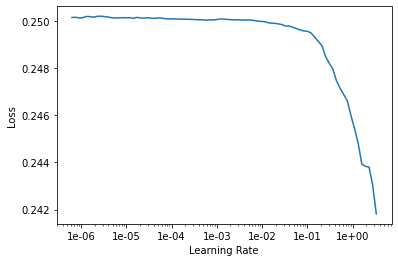

In [12]:
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(15, 0.5)

epoch,train_loss,valid_loss,auc_roc_score,time
0,0.198311,0.198308,0.565006,01:16
1,0.207386,0.209035,0.551610,01:17
2,0.218523,0.217475,0.545686,01:16
3,0.222355,0.221154,0.548066,01:17
4,0.221198,0.220729,0.545082,01:15
5,0.224445,0.220249,0.544680,01:15
6,0.219365,0.219558,0.552717,01:14
7,0.213130,0.215765,0.551946,01:14
8,0.215547,0.213569,0.548283,01:14
9,0.210640,0.208130,0.554731,01:14


In [14]:
learn.model.parameters()

<generator object Module.parameters at 0x7f95133108e0>

In [21]:
#добавляю оптимизацию параметров
learn.opt = optim.SGD(params = learn.model.parameters(), lr = 0.5, momentum = 0.9)
learn.opt.mom = 0.9
learn.fit(15, lr = 0.5)

epoch,train_loss,valid_loss,auc_roc_score,time
0,0.018469,0.119025,0.738829,01:10
1,0.017382,0.119055,0.738756,01:08


Exception in thread Thread-125:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 294, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/pyth

KeyboardInterrupt: ignored

In [0]:
 learn.save('items-recsys_5')

In [0]:
print(learn.summary())

In [0]:
#оптимизация параметров через gridsearch
%time

param_grid = {
            'epochs': [1, 3],
            'n_factors': [30, 200],
            #"lr": np.random.exponential(0.05),
            #'n_epochs': [15, 20],
             # 'lr_all': [0.09, 0.12],
             # 'reg_all': [0.8, 0.7]
             }
gs = GridSearchCV(learn, param_grid, scoring='roc_auc', cv=3)

gs.fit(train)

# best 'roc_auc' score
print(gs.best_score)

# combination of parameters that gave the best 'roc_auc' score
print(gs.best_params)

In [0]:
#делаем предсказания на тесте
data_collab = CollabDataBunch.from_df(train,test=test, seed=42, valid_pct=VAL_SIZE, user_name='userid', item_name='itemid', rating_name='rating')

In [0]:
learn = collab_learner(data_collab, use_nn=True, emb_szs={'userid': 40, 'itemid':40}, layers=[256, 128],y_range=(0.0, 1.0))

In [0]:
for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [0]:
learn_loaded = learn.load('items-recsys_5')

In [0]:
preds, y = learn_loaded.get_preds(DatasetType.Test)

In [0]:
preds = preds.tolist()

In [0]:
preds_num = np.array(preds)

In [0]:
preds_num.min(), preds_num.max()

In [0]:
normalized_preds = (preds_num - preds_num.min())/(preds_num - preds_num.min()).max()
normalized_preds.min(), normalized_preds.max()

In [0]:
sabmission['rating'] = normalized_preds

In [0]:
sabmission = sabmission.set_index('Id')

In [0]:
sabmission.head()

In [0]:
sabmission.to_csv('submission_fastai.csv')

In [0]:
#sklearn.metrics.roc_auc_score(train.rating,pred)